In [73]:
import numpy
from matplotlib import pyplot
import matplotlib as mpl
import sys
sys.path.append('../src/')
import densities, factors

In [2]:
mpl.rcParams['font.size'] = 12
#mpl.rcParams['text.usetex'] = True

In [44]:
R_mu = 100
R_sigma = 4
R = R_mu * R_sigma
mu_range = numpy.linspace(0,10, R_mu)
sigma_range = numpy.linspace(1,10, R_sigma)
MU, SIGMA = numpy.meshgrid(mu_range, sigma_range)
mu_mesh = MU.T.flatten()
sigma_mesh = SIGMA.T.flatten()
mu_phi = numpy.zeros((R,1))
mu_phi[:,0] = mu_mesh
sigma_phi = numpy.ones((R,1,1))
sigma_phi[:,0,0] = sigma_mesh 
phi = densities.GaussianDensity(sigma_phi, mu_phi)

In [45]:
sigma_range

array([ 1.,  4.,  7., 10.])

$-\ln (\sigma^2 + \cosh(h))$

In [46]:
sigma2 = 1.
f = lambda h: -numpy.log(sigma2 + 2*numpy.cosh(h))
g = lambda omega: 2 * numpy.sinh(omega) / (numpy.sqrt(omega ** 2) * (sigma2 + 2 * numpy.cosh(omega)))
k = lambda h, omega: numpy.log(sigma2 + 2 * numpy.cosh(omega)) + .5 * g(omega) * (h ** 2 - omega ** 2)
omega_dagger = numpy.sqrt(phi.integrate('xx'))
f_lb = -k(omega_dagger, omega_dagger).reshape((R_mu, R_sigma))
f_sample = numpy.mean(f(phi.sample(100000)), axis=0).reshape((R_mu, R_sigma))

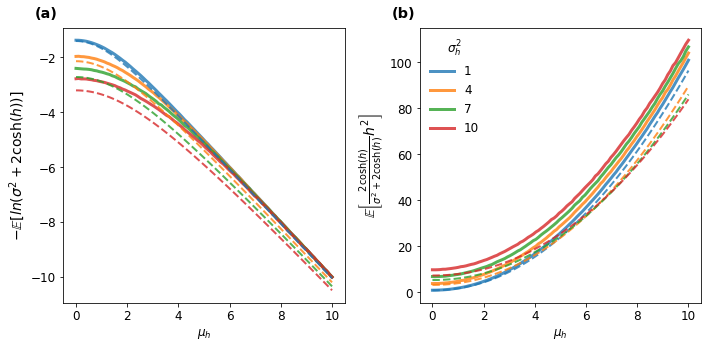

In [129]:
pyplot.figure(figsize=(10,5))
pyplot.subplot(121)
for r in range(R_sigma):
    pyplot.plot(mu_range, f_sample[:,r], 'C%d' %r, alpha=.8, label='%d' % sigma_range[r], lw=3)
    pyplot.plot(mu_range, f_lb[:,r], 'C%d--' %r, alpha=.8, lw=2, zorder=9)
pyplot.xlabel('$\mu_h$')
pyplot.ylabel('$- \mathbb{E}\\left[ ln(\sigma^2 + 2\cosh(h))\\right]$', size=14)
pyplot.title('(a)', loc='left', x=-.1, pad=10, weight='bold')
pyplot.subplot(122)
for r in range(R_sigma):
    pyplot.plot(mu_range, f2_sample[:,r], 'C%d' %r, alpha=.8, label='%d' % sigma_range[r], lw=3)
    pyplot.plot(mu_range, f2_lb[:,r], 'C%d--' %r, alpha=.8, lw=2, zorder=9)
pyplot.ylabel('$\mathbb{E}\\left[\\frac{2\cosh(h)}{\sigma^2 + 2\cosh(h)} h^2\\right]$', size=14)
pyplot.legend(title='$\sigma_h^2$', frameon=False)
pyplot.xlabel('$\mu_h$')
pyplot.title('(b)', loc='left', x=-.1, pad=10, weight='bold')
pyplot.tight_layout()
pyplot.savefig('../figs/aistats22/lb.pdf')

In [65]:
f2 = lambda h: 2 * numpy.cosh(h) / (sigma2 + 2*numpy.cosh(h)) * h ** 2
f2_sample = numpy.mean(f2(phi.sample(100000)), axis=0).reshape((R_mu, R_sigma))

In [89]:
omega_star = numpy.ones(R)
conv_crit = 1e-4
converged = False
while not converged:
    g_omega = g(omega_star)
    nu_plus = (1. - g_omega[:,None] * 0)
    nu_minus = (-1. - g_omega[:,None] * 0)
    v = numpy.ones((R, 1))
    ln_beta = - numpy.log(sigma2 + 2 * numpy.cosh(omega_star)) - .5 * g_omega * (- omega_star ** 2)
    ln_beta_plus = ln_beta
    ln_beta_minus = ln_beta
    # Create OneRankFactors
    exp_factor_plus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_plus, ln_beta=ln_beta_plus)
    exp_factor_minus = factors.OneRankFactor(v=v, g=g_omega, nu=nu_minus, ln_beta=ln_beta_minus)
    # Create the two measures
    exp_phi_plus = phi.hadamard(exp_factor_plus)
    exp_phi_minus = phi.hadamard(exp_factor_minus)

    quart_int_plus = exp_phi_plus.integrate('Ax_aBx_bCx_cDx_d_inner')
    quart_int_minus = exp_phi_minus.integrate('Ax_aBx_bCx_cDx_d_inner')
    quart_int = quart_int_plus + quart_int_minus

    quad_int_plus = exp_phi_plus.integrate('Ax_aBx_b_inner')
    quad_int_minus = exp_phi_minus.integrate('Ax_aBx_b_inner')
    quad_int = quad_int_plus + quad_int_minus
    omega_old = omega_star
    omega_star = numpy.sqrt(numpy.abs(quart_int / quad_int))
    converged = numpy.amax(numpy.abs(omega_star - omega_old)) < conv_crit

In [92]:
f2_lb = quad_int_plus + quad_int_minus
f2_lb = f2_lb.reshape((R_mu, R_sigma))

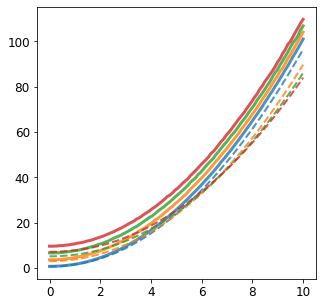